# Classification


## importing packages



In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, date
from datetime import timedelta
import matplotlib.pyplot as plt
import itertools

# Classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# Preprocessing:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest

# crossvalidation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

# evaluation:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import classification_report

## Set up functions

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## Data Preparation and Split

In [9]:
data = pd.read_csv("../data/processed/all_features_with_further_preprocessing.csv")

# load G to get dates:
import sys
from os.path import join, dirname
from os import pardir
sys.path.insert(1, join(pardir, "src", "data"))
sys.path.insert(1, join(pardir, pardir, "data", "processed"))
from graphio import read_graph
G = read_graph("hep-th-citations_unzipped.txt", "hep-th-slacdates_unzipped.txt")

# remove last_year:
last_date = date(2003, 5, 1)
delta = timedelta(days=365)
data["not_last_year"] = data["paper_id"].apply(lambda x: G.nodes[x]["time"] <= last_date - delta)
data = data[data["not_last_year"]]


# drop rows with target = NaN
data = data[data["label"]==data["label"]]

# replace NaN in journal_counts with 0:
data.loc[(data["journal_counts"]>=0)==False, "journal_counts"]=0
# replace NaN with 10 for num_of_pages
data.loc[data["num_of_pages"]!=data["num_of_pages"], "num_of_pages"] = 10
# replace NaN with 0
data.loc[data["recency_of_cited_papers_avg"]!=data["recency_of_cited_papers_avg"], "recency_of_cited_papers_avg"] = 0
data.loc[data["max_time_difference_bw_cited_papers"]!=data["max_time_difference_bw_cited_papers"], "max_time_difference_bw_cited_papers"] = 0


# split in train and test
data["is_train"] = data["paper_id"].apply(lambda x: G.nodes[x]["time"] <= last_date - 2*delta)
data["is_test"] = data["paper_id"].apply(lambda x: G.nodes[x]["time"] > last_date - 2*delta)
data_train = data[data["is_train"]]
data_test = data[data["is_test"]]





loading Graph...
delete future citations...
Graph loaded.


In [10]:
data.head(10)
data.columns

Index(['Unnamed: 0', 'paper_id', 'indegrees_of_cited_papers_sum',
       'indegrees_of_cited_papers_avg', 'recency_of_cited_papers_avg',
       'max_time_difference_bw_cited_papers', 'outdegree',
       'outdegrees_of_cited_papers_sum', 'outdegrees_of_cited_papers_avg',
       'submitter', 'submission_date', 'title', 'authors', 'comments',
       'report_no', 'journal_ref', 'abstract', 'submitter_email',
       'submitter_name', 'submitter_details', 'is_revised', 'times_revised',
       'first_submission_datetime', 'first_submission_date', 'num_of_pages',
       'format', 'journal_counts', 'first_365_days', 'label', 'label_name',
       'submitter_active', 'submitter_counts', 'journal_popularity',
       'format_latex', 'format_revtex', 'format_harvmac', 'format_plaintex',
       'date_added_graph', 'datedelta', 'citations_till_date', 'not_last_year',
       'is_train', 'is_test'],
      dtype='object')

In [11]:
target_train = data_train["label"]
target_test = data_test["label"]
features = ['indegrees_of_cited_papers_sum',
       'indegrees_of_cited_papers_avg', 'recency_of_cited_papers_avg',
       'max_time_difference_bw_cited_papers', 'outdegree',
       'outdegrees_of_cited_papers_sum', 'outdegrees_of_cited_papers_avg', 'num_of_pages',
       'journal_counts',
       'submitter_active', 'submitter_counts', 'journal_popularity',
       'format_latex', 'format_revtex', 'format_harvmac', 'format_plaintex']
data_train = data_train[features]
data_test = data_test[features]

In [12]:
data_train.head(10)

,indegrees_of_cited_papers_sum,indegrees_of_cited_papers_avg,recency_of_cited_papers_avg,max_time_difference_bw_cited_papers,outdegree,outdegrees_of_cited_papers_sum,outdegrees_of_cited_papers_avg,num_of_pages,journal_counts,submitter_active,submitter_counts,journal_popularity,format_latex,format_revtex,format_harvmac,format_plaintex
0,317,31.700000,523.000000,947.0,10,99,9.900000,15.0,13.0,0,4,1,0,0,0,0
1,175,19.444444,146.333333,448.0,9,86,9.555556,13.0,8.0,0,3,0,0,0,1,0
2,39,6.500000,705.000000,959.0,6,11,1.833333,16.0,5.0,0,3,0,1,0,0,0
3,222,20.181818,273.272727,909.0,11,116,10.545455,10.0,0.0,0,4,0,1,0,0,0
4,14,4.666667,357.333333,459.0,3,10,3.333333,1.0,31.0,0,1,1,1,0,0,0
5,11,2.750000,734.250000,630.0,4,4,1.000000,6.0,0.0,1,5,0,1,0,0,0
6,39,3.250000,840.916667,882.0,12,54,4.500000,21.0,102.0,0,1,1,1,0,0,0
7,262,18.714286,618.714286,1236.0,14,62,4.428571,10.0,21.0,1,7,1,1,0,0,0
8,31,4.428571,648.000000,861.0,7,11,1.571429,12.0,2.0,0,3,0,1,0,0,0
9,32,10.666667,782.000000,644.0,3,12,4.000000,105.0,0.0,1,7,0,1,0,0,0


# Decision Tree Classifier


In [22]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

class_weight = {0: 5044, 1: 9509, 2: 1103, 3: 840}
gridsearch_parameters = [{'classification': (DecisionTreeClassifier(class_weight=class_weight),),
                        'classification__min_samples_split': (5,),
                        'classification__criterion': ('entropy',),
                        'classification__max_depth': (None,),
                        'feature_selection__k': (13,)}]
pipeline = Pipeline([("scaler", StandardScaler()), ("feature_selection", SelectKBest(k="all")), ("classification", DecisionTreeClassifier())])



grid_search_estimator = GridSearchCV(pipeline, gridsearch_parameters, scoring='f1_macro',cv=cv, return_train_score=True)

grid_search_estimator.fit(data_train, target_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('feature_selection',
                                        SelectKBest(k='all')),
                                       ('classification',
                                        DecisionTreeClassifier())]),
             param_grid=[{'classification': (DecisionTreeClassifier(class_weight={0: 5044,
                                                                                  1: 9509,
                                                                                  2: 1103,
                                                                                  3: 840},
                                                                    criterion='entropy',
                                                                    min_samples_split=5),),
                          'classification__criterion': ('en

Best parameters: 
classification : DecisionTreeClassifier(class_weight={0: 5044, 1: 9509, 2: 1103, 3: 840},
                       criterion='entropy', min_samples_split=5)
classification__criterion : entropy
classification__max_depth : None
classification__min_samples_split : 5
feature_selection__k : 13

Mean Train Scores:
 [0.88028937]
Mean Test Scores:
 [0.38163361]

              precision    recall  f1-score   support

         0.0       0.39      0.44      0.42       725
         1.0       0.64      0.63      0.64      1904
         2.0       0.18      0.18      0.18       259
         3.0       0.17      0.13      0.15       200

    accuracy                           0.52      3088
   macro avg       0.35      0.35      0.34      3088
weighted avg       0.51      0.52      0.51      3088



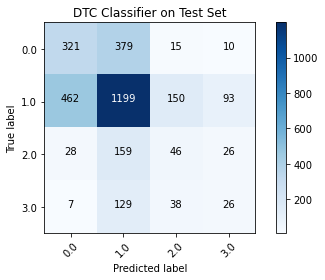

In [23]:
print("Best parameters: ")
for a,b in grid_search_estimator.best_params_.items():
    print(a , ":", b)
print()

print("Mean Train Scores:\n", grid_search_estimator.cv_results_['mean_train_score'])
print("Mean Test Scores:\n", grid_search_estimator.cv_results_['mean_test_score'])
print()

prediction = grid_search_estimator.predict(data_test)
cm = confusion_matrix(target_test, prediction)
plot_confusion_matrix(cm, classes = unique_labels(target_test), title = "DTC Classifier on Test Set")
print(classification_report(target_test, prediction))

In [64]:
feature_numbers = grid_search_estimator.best_estimator_.named_steps["feature_selection"].get_support(indices=True)
print(grid_search_estimator.best_estimator_.named_steps["feature_selection"].get_support(indices=True))
feature_names = [features[i] for i in feature_numbers]
print(feature_names)
impor = grid_search_estimator.best_estimator_.named_steps["classification"].feature_importances_
print(grid_search_estimator.best_estimator_.named_steps["classification"].feature_importances_)
df = pd.DataFrame(feature_names , columns = ["feature_names"])
df["importance"]= impor
df = df.sort_values(by=["importance"], ascending=False)
df.head(13)


[ 0  1  2  3  4  5  6  7  8  9 10 11 14]
['indegrees_of_cited_papers_sum', 'indegrees_of_cited_papers_avg', 'recency_of_cited_papers_avg', 'max_time_difference_bw_cited_papers', 'outdegree', 'outdegrees_of_cited_papers_sum', 'outdegrees_of_cited_papers_avg', 'num_of_pages', 'journal_counts', 'submitter_active', 'submitter_counts', 'journal_popularity', 'format_harvmac']
[0.07071955 0.074447   0.16224436 0.10165206 0.04521724 0.13737825
 0.08165365 0.13497327 0.11709614 0.00455481 0.0596554  0.00317539
 0.00723289]


,feature_names,importance
2,recency_of_cited_papers_avg,0.162244
5,outdegrees_of_cited_papers_sum,0.137378
7,num_of_pages,0.134973
8,journal_counts,0.117096
3,max_time_difference_bw_cited_papers,0.101652
6,outdegrees_of_cited_papers_avg,0.081654
1,indegrees_of_cited_papers_avg,0.074447
0,indegrees_of_cited_papers_sum,0.070720
10,submitter_counts,0.059655
4,outdegree,0.045217


# GradientBoostingClassifier

In [65]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

class_weight = {0: 5044, 1: 9509, 2: 1103, 3: 840}
# Note: there is no class_weight possibility for Gradient Boosting Classifier
gridsearch_parameters = [{'classification': (GradientBoostingClassifier(),),#class_weight=class_weight),),
                        'classification__min_samples_split': (5,),
                        'classification__criterion': ( 'mse',),
                        'classification__max_depth': ( 7,),
                        'feature_selection__k': (10, )}]
pipeline = Pipeline([("scaler", StandardScaler()), ("feature_selection", SelectKBest(k="all")), ("classification", None)])



grid_search_estimator = GridSearchCV(pipeline, gridsearch_parameters, scoring='f1_macro',cv=cv, return_train_score=True)

grid_search_estimator.fit(data_train, target_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('feature_selection',
                                        SelectKBest(k='all')),
                                       ('classification', None)]),
             param_grid=[{'classification': (GradientBoostingClassifier(criterion='mse',
                                                                        max_depth=7,
                                                                        min_samples_split=5),),
                          'classification__criterion': ('mse',),
                          'classification__max_depth': (7,),
                          'classification__min_samples_split': (5,),
                          'feature_selection__k': (10,)}],
             return_train_score=True, scoring='f1_macro')

Best parameters: 
classification : GradientBoostingClassifier(criterion='mse', max_depth=7, min_samples_split=5)
classification__criterion : mse
classification__max_depth : 7
classification__min_samples_split : 5
feature_selection__k : 10

Mean Train Scores:
 [0.77710134]
Mean Test Scores:
 [0.37015914]

              precision    recall  f1-score   support

         0.0       0.53      0.29      0.37       725
         1.0       0.64      0.88      0.74      1904
         2.0       0.18      0.03      0.06       259
         3.0       0.25      0.07      0.10       200

    accuracy                           0.61      3088
   macro avg       0.40      0.32      0.32      3088
weighted avg       0.55      0.61      0.56      3088



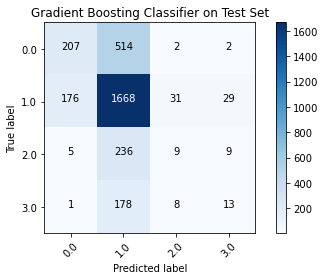

In [66]:
print("Best parameters: ")
for a,b in grid_search_estimator.best_params_.items():
    print(a , ":", b)
print()

print("Mean Train Scores:\n", grid_search_estimator.cv_results_['mean_train_score'])
print("Mean Test Scores:\n", grid_search_estimator.cv_results_['mean_test_score'])
print()

prediction = grid_search_estimator.predict(data_test)
cm = confusion_matrix(target_test, prediction)
plot_confusion_matrix(cm, classes = unique_labels(target_test), title = "Gradient Boosting Classifier on Test Set")
print(classification_report(target_test, prediction))

In [67]:
feature_numbers = grid_search_estimator.best_estimator_.named_steps["feature_selection"].get_support(indices=True)
print(grid_search_estimator.best_estimator_.named_steps["feature_selection"].get_support(indices=True))
feature_names = [features[i] for i in feature_numbers]
print(feature_names)
impor = grid_search_estimator.best_estimator_.named_steps["classification"].feature_importances_
print(grid_search_estimator.best_estimator_.named_steps["classification"].feature_importances_)
df = pd.DataFrame(feature_names , columns = ["feature_names"])
df["importance"]= impor
df = df.sort_values(by=["importance"], ascending=False)
df.head(13)

[ 0  1  3  4  5  6  9 10 11 14]
['indegrees_of_cited_papers_sum', 'indegrees_of_cited_papers_avg', 'max_time_difference_bw_cited_papers', 'outdegree', 'outdegrees_of_cited_papers_sum', 'outdegrees_of_cited_papers_avg', 'submitter_active', 'submitter_counts', 'journal_popularity', 'format_harvmac']
[0.09540629 0.12148228 0.16477127 0.07109793 0.29412065 0.1207189
 0.00283634 0.08342222 0.02525864 0.02088549]


,feature_names,importance
4,outdegrees_of_cited_papers_sum,0.294121
2,max_time_difference_bw_cited_papers,0.164771
1,indegrees_of_cited_papers_avg,0.121482
5,outdegrees_of_cited_papers_avg,0.120719
0,indegrees_of_cited_papers_sum,0.095406
7,submitter_counts,0.083422
3,outdegree,0.071098
8,journal_popularity,0.025259
9,format_harvmac,0.020885
6,submitter_active,0.002836


# SVM

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

class_weight = {0: 5044, 1: 9509, 2: 1103, 3: 840}
gridsearch_parameters = [{'classification': (SVC(class_weight=class_weight),),
                        'classification__kernel': ('poly',),
                        'classification__max_iter': (-1,),
                        'feature_selection__k': (10,)}]
pipeline = Pipeline([("scaler", StandardScaler()), ("feature_selection", SelectKBest(k="all")), ("classification", None)])



grid_search_estimator = GridSearchCV(pipeline, gridsearch_parameters, scoring='f1_macro',cv=cv, return_train_score=True)

grid_search_estimator.fit(data_train, target_train)

In [ ]:
print("Best parameters: ")
for a,b in grid_search_estimator.best_params_.items():
    print(a , ":", b)
print()

print("Mean Train Scores:\n", grid_search_estimator.cv_results_['mean_train_score'])
print("Mean Test Scores:\n", grid_search_estimator.cv_results_['mean_test_score'])
print()

prediction = grid_search_estimator.predict(data_test)
cm = confusion_matrix(target_test, prediction)
plot_confusion_matrix(cm, classes = unique_labels(target_test), title = "SVC on Test Set")
print(classification_report(target_test, prediction))

# Random Forest Classifier

In [68]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

class_weight = {0: 5044, 1: 9509, 2: 1103, 3: 840}
gridsearch_parameters = [{'classification': (RandomForestClassifier(class_weight=class_weight),),
                        'classification__min_samples_leaf': (5, ),
                        'classification__n_estimators': (150,),
                        'classification__max_depth': (None,),
                        'classification__criterion': ( 'entropy',),
                        'feature_selection__k': (11,)}]
pipeline = Pipeline([("scaler", StandardScaler()), ("feature_selection", SelectKBest(k="all")), ("classification", None)])



grid_search_estimator = GridSearchCV(pipeline, gridsearch_parameters, scoring='f1_macro',cv=cv, return_train_score=True)

grid_search_estimator.fit(data_train, target_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('feature_selection',
                                        SelectKBest(k='all')),
                                       ('classification', None)]),
             param_grid=[{'classification': (RandomForestClassifier(class_weight={0: 5044,
                                                                                  1: 9509,
                                                                                  2: 1103,
                                                                                  3: 840},
                                                                    criterion='entropy',
                                                                    min_samples_leaf=5,
                                                                    n_estimators=150),),
                          'classif

Best parameters: 
classification : RandomForestClassifier(class_weight={0: 5044, 1: 9509, 2: 1103, 3: 840},
                       criterion='entropy', min_samples_leaf=5,
                       n_estimators=150)
classification__criterion : entropy
classification__max_depth : None
classification__min_samples_leaf : 5
classification__n_estimators : 150
feature_selection__k : 11

Mean Train Scores:
 [0.36683226]
Mean Test Scores:
 [0.25210488]

              precision    recall  f1-score   support

         0.0       0.64      0.15      0.24       725
         1.0       0.63      0.97      0.76      1904
         2.0       0.00      0.00      0.00       259
         3.0       0.00      0.00      0.00       200

    accuracy                           0.63      3088
   macro avg       0.32      0.28      0.25      3088
weighted avg       0.54      0.63      0.53      3088



C:\Users\Win10\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Win10\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Win10\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


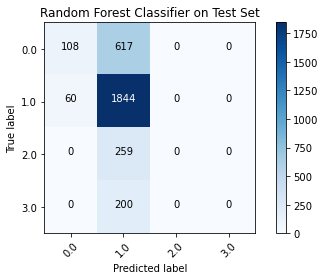

In [69]:
print("Best parameters: ")
for a,b in grid_search_estimator.best_params_.items():
    print(a , ":", b)
print()

print("Mean Train Scores:\n", grid_search_estimator.cv_results_['mean_train_score'])
print("Mean Test Scores:\n", grid_search_estimator.cv_results_['mean_test_score'])
print()

prediction = grid_search_estimator.predict(data_test)
cm = confusion_matrix(target_test, prediction)
plot_confusion_matrix(cm, classes = unique_labels(target_test), title = "Random Forest Classifier on Test Set")
print(classification_report(target_test, prediction))

In [70]:
feature_numbers = grid_search_estimator.best_estimator_.named_steps["feature_selection"].get_support(indices=True)
print(grid_search_estimator.best_estimator_.named_steps["feature_selection"].get_support(indices=True))
feature_names = [features[i] for i in feature_numbers]
print(feature_names)
impor = grid_search_estimator.best_estimator_.named_steps["classification"].feature_importances_
print(grid_search_estimator.best_estimator_.named_steps["classification"].feature_importances_)
df = pd.DataFrame(feature_names , columns = ["feature_names"])
df["importance"]= impor
df = df.sort_values(by=["importance"], ascending=False)
df.head(13)

[ 0  1  2  3  4  5  6  9 10 11 14]
['indegrees_of_cited_papers_sum', 'indegrees_of_cited_papers_avg', 'recency_of_cited_papers_avg', 'max_time_difference_bw_cited_papers', 'outdegree', 'outdegrees_of_cited_papers_sum', 'outdegrees_of_cited_papers_avg', 'submitter_active', 'submitter_counts', 'journal_popularity', 'format_harvmac']
[0.12067767 0.10660574 0.17220063 0.11726175 0.10379829 0.14223841
 0.12162673 0.01099347 0.07128985 0.02591545 0.00739199]


,feature_names,importance
2,recency_of_cited_papers_avg,0.172201
5,outdegrees_of_cited_papers_sum,0.142238
6,outdegrees_of_cited_papers_avg,0.121627
0,indegrees_of_cited_papers_sum,0.120678
3,max_time_difference_bw_cited_papers,0.117262
1,indegrees_of_cited_papers_avg,0.106606
4,outdegree,0.103798
8,submitter_counts,0.071290
9,journal_popularity,0.025915
7,submitter_active,0.010993
